# Inferencing Hand-pose

In [ ]:
!git clone https://github.com/IcarusWizard/PixelwiseRegression.git

Cloning into 'PixelwiseRegression'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 316 (delta 92), reused 92 (delta 54), pack-reused 175
Receiving objects: 100% (316/316), 1.61 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [ ]:
%cd /content/PixelwiseRegression/Data/ICVL
!gdown -q 1fcsmlGEbuCS-KYNaiUHCAKid7r45gXa6
!unzip -q ICVL.zip
!rm ICVL.zip
%cd /content/PixelwiseRegression/
!pip install -q ray
!gdown -q 1K_X0NAwUbdwyGPU4CAUQ_7P9KiURNUaK
!mkdir Model
!rm check_dataset.py check_samples.py env.yml get_sfr.py readme.md requirements.txt test.py test_fullregression.py test_msra.py train.py train_fullregression.py train_msra.py LICENSE
!rm -rf /content/PixelwiseRegression/Data/NYU
%cd Model
!gdown -q 1IhvTfRAd-dbNGaCOqup_HC6MSOkN7tvR
%cd /content/PixelwiseRegression/

/content/PixelwiseRegression/Data/ICVL
/content/PixelwiseRegression
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 11.3 MB/s eta 0:00:00
/content/PixelwiseRegression/Model
/content/PixelwiseRegression


In [ ]:
import cv2
import numpy as np
import os, argparse
from tqdm import tqdm
import torch, torchvision
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import datasets
from PixelwiseRegression.model import PixelwiseRegression
from PixelwiseRegression.utils import load_model, select_gpus

In [ ]:
def draw_skeleton(_img, joints, *, output_size=512, rP = 8, linewidth = 4, draw=False, skeleton_mode=0):
    fig, axes = plt.subplots(figsize=(4, 4))
    if joints.shape[0] == 16:
            Index = [0, 4, 5, 6]
            Mid = [0, 7, 8, 9]
            Ring = [0, 10, 11, 12]
            Small = [0, 13, 14, 15]
            Thumb = [0, 1, 2, 3]
            config = [Thumb, Index, Mid, Ring, Small]

        # print(f"image shape: {_img.shape}")
    img = cv2.resize(_img, (output_size, output_size))
    img3D = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(3):
        img3D[:, :, i] = img
    is_hand = img3D != 0
    img3D = img3D / np.max(img3D)
    # img3D = img3D * 0.5 + 0.25
    img3D = 1 - img3D
    img3D[is_hand] *= 0.5
    joints = joints * (img.shape[0] - 1) + np.array([img.shape[0] // 2, img.shape[0] // 2])
    _joint = [(int(joints[i][0]), int(joints[i][1])) for i in range(joints.shape[0])]
    colors = [(1, 0, 0), (0.5, 0.5, 0), (0, 1, 0), (0, 0.5, 0.5), (0, 0, 1)]

    print(f"Predicted_joints: {_joint}\n")
    for i in range(5):
        for index in config[i]:
            cv2.circle(img3D, _joint[index], rP, colors[i], -1)

        for j in range(len(config[i]) - 1):
            cv2.line(img3D, _joint[config[i][j]], _joint[config[i][j+1]], colors[i], linewidth)

    if draw:
        axes.imshow(img3D)
        axes.axis("off")
        plt.show()
    else:
        return img3D

building text.txt ...
saving text.txt ...
building train.txt ...
checking data ......


2023-05-25 09:06:22,444	INFO worker.py:1625 -- Started a local Ray instance.
0it [00:00, ?it/s]


0 / 0 data can use to train
Predicted_joints: [(264, 346), (209, 376), (148, 340), (106, 307), (209, 243), (196, 187), (186, 150), (259, 242), (269, 175), (274, 132), (299, 265), (318, 206), (331, 166), (340, 293), (370, 257), (396, 229)]



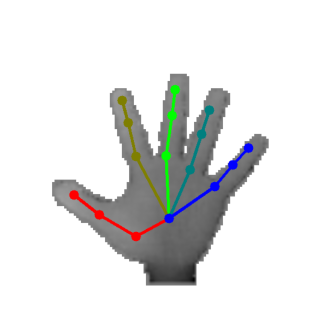

In [ ]:
if not os.path.exists("skeleton"):
    os.mkdir("skeleton")

if not os.path.exists(os.path.join("skeleton", 'ICVL')):
    os.mkdir(os.path.join("skeleton", 'ICVL'))
    os.mkdir(os.path.join("skeleton", 'ICVL', "predict"))
    os.mkdir(os.path.join("skeleton", 'ICVL', "gt"))

dataset_parameters = {
    "image_size" : 64 * 2,
    "label_size" : 64,
    "kernel_size" : 7,
    "sigmoid" : 1.5,
    "dataset" : "val",
    "test_only" : False,
}

test_loader_parameters = {
    "batch_size" : 1,
    "shuffle" : True,
    "pin_memory" : True,
    "drop_last" : False,
    "num_workers" : min(1, os.cpu_count()),
}

model_parameters = {
    "stage" : 2,
    "label_size" : 64,
    "features" : 128,
    "level" : 4,
    "norm_method" : 'instance',
    "heatmap_method" : 'softmax',
}

model_name = "ICVL_default_final.pt"

Dataset = getattr(datasets, "{}Dataset".format('ICVL'))
testset = Dataset(**dataset_parameters)

joints = testset.joint_number
config = testset.config
threshold = testset.cube_size
skeleton_mode = 0

test_loader = torch.utils.data.DataLoader(testset, **test_loader_parameters)

select_gpus('0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = PixelwiseRegression(joints, **model_parameters)
load_model(model, os.path.join('Model', model_name), eval_mode=True)
model = model.to(device)

index = 0
for batch in iter(test_loader):
    img, label_img, mask, box_size, cube_size, com, uvd, heatmaps, depthmaps = batch

    img = img.to(device, non_blocking=True)
    label_img = label_img.to(device, non_blocking=True)
    mask = mask.to(device, non_blocking=True)

    results = model(img, label_img, mask)

    _heatmaps, _depthmaps, _uvd = results[-1]

    _uvd = _uvd.detach().cpu().numpy()
    img = img.cpu().numpy()
    uvd = uvd.numpy()

    skeleton_pre = draw_skeleton(img[0,0], _uvd[0,:,:2], draw=True, skeleton_mode=skeleton_mode)

# Center of Mass

<ipython-input-6-df934dc85e85>:1: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass # PixelwiseRegression/dataset.py [line: 6]



com: (119.5, 159.5)
mean: 0.4219089150428772
_com: [159.5        119.5          0.42190892]



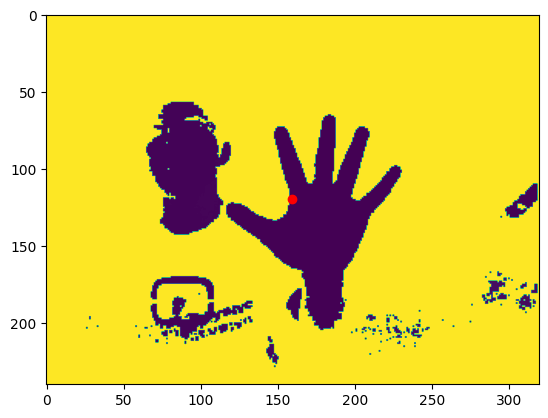

In [ ]:
from scipy.ndimage.measurements import center_of_mass # PixelwiseRegression/dataset.py [line: 6]

img = plt.imread('/content/PixelwiseRegression/Data/ICVL/Testing/Depth/test_seq_1/image_0000.png')
type(img)

mean = np.mean(img[img > 0])
com = center_of_mass(img > 0)
print(f"\ncom: {com}\nmean: {mean}")
_com = np.array([com[1], com[0], mean])
print(f"_com: {_com}\n")


plt.imshow(img)
plt.scatter(_com[0], _com[1], color='red')
plt.show()